In [1]:
'''
Notebook to debug figure plots, e.g. sampling from memory
'''

import os

import cmws
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from cmws import util
from cmws.examples.scene_understanding import data, render, run
from cmws.examples.scene_understanding import util as scene3d_util 
import seaborn as sns
import numpy as np
from cmws.examples.scene_understanding.plot import *


def importance_sample_memory(
    num_particles, obs, obs_id, generative_model, guide, memory, img_size=256
):
    # modifed from: https://github.com/tuananhle7/continuous_mws/blob/a43dd325e1e2c765d9811773ff5885b6f5f400e4/cmws/examples/timeseries/inference.py#L239
    """
    Args
        num_particles
        num_svi_iterations
        obs [batch_size, num_timesteps]
        obs_id [batch_size]
        generative_model
        guide
        memory
    Returns
        latent
            raw_expression [memory_size, batch_size, max_num_chars]
            eos [memory_size, batch_size, max_num_chars]
            raw_gp_params [memory_size, batch_size, max_num_chars, gp_params_dim]
        log_marginal_joint [memory_size, batch_size]
    """
    # Extract
    batch_size = obs.shape[0]
    memory_size = memory.size
    
    print("sampling discrete")

    # Sample discrete latent
    # [memory_size, batch_size, ...]
    discrete_latent = memory.select(obs_id)
    
    print("computing scores")

    # COMPUTE SCORES s_i = log p(d_i, x) for i  {1, ..., M}
    # [memory_size, batch_size]
    log_marginal_joint = cmws.losses.get_log_marginal_joint(
        generative_model, guide, discrete_latent, obs, num_particles
    )
    
    print("expanding and getting continuous")

    # Sample svi-optimized q(z_c | z_d, x)
    # -- Expand obs
    # [memory_size, batch_size, 3, img_size, img_size]
    obs_expanded = obs[None].expand([memory_size, batch_size, 3, img_size, img_size])
    # -- SVI
    continuous_latent = guide.sample_continuous(obs_expanded, discrete_latent)

    # Combine latents
    latent = discrete_latent[0], discrete_latent[1], continuous_latent

    return latent, log_marginal_joint


In [2]:
experiment_name = "cmws_vs_rws_noColor"
device = "cpu"
save_dir = f"../save/{experiment_name}"
checkpoint_paths = []
for config_name in sorted(os.listdir(save_dir)):
    checkpoint_paths.append(util.get_checkpoint_path(experiment_name, config_name, -1))
checkpoint_path = f'save/{experiment_name}/cmws_5_2_0.01_2/checkpoints/latest.pt'#checkpoint_paths[0]
checkpoint_path = f"../{checkpoint_path}"
model, optimizer, stats, run_args = scene3d_util.load_checkpoint(
                            checkpoint_path, device="cpu"
                        )
generative_model, guide = model["generative_model"], model["guide"]
num_iterations = len(stats.losses) # note: can use to filter out jobs!
save_dir = util.get_save_dir(run_args.experiment_name, run.get_config_name(run_args))

# Plot stats
plot_stats(f"{save_dir}/stats.png", stats)

# Plot reconstructions and other things
# Test data
# NOTE: Plotting the train dataset only
train_dataset = data.SceneUnderstandingDataset(
    device, run_args.num_grid_rows, run_args.num_grid_cols, test=False,
    remove_color=(run_args.remove_color == 1),
    mode=run_args.mode
)
obs, obs_id = train_dataset[:70]#train_dataset[50:80]


color status:  True
path:  /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/1_1/cube_0.01/colorless/train.pt
12:35:05 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:348 | INFO: Loading dataset (test = False)...
12:35:05 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:352 | INFO: Dataset (test = False) loaded /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/1_1/cube_0.01/colorless/train.pt
12:35:05 | /om/user/katiemc/continuous_mws/cmws/memory.py:20 | INFO: Initializing memory


100%|██████████| 100/100 [00:00<00:00, 951.59it/s]


12:35:06 | /om/user/katiemc/continuous_mws/cmws/util.py:293 | INFO: Saved to save/cmws_vs_rws_noColor/cmws_5_2_0.01_2/stats.png
color status:  True
path:  /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/2_2/cube_0.01/colorless/train.pt
12:35:06 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:348 | INFO: Loading dataset (test = False)...
12:35:06 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:352 | INFO: Dataset (test = False) loaded /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/2_2/cube_0.01/colorless/train.pt


In [3]:
memory = model["memory"]
(run_args.remove_color == 1)

True

In [4]:
obs = obs.squeeze(1)
num_test_obs, num_channels, im_size, _ = obs.shape
im_size = 128
num_samples = 1

num_particles = memory.size
latent, log_weight = importance_sample_memory(
    num_particles, obs, obs_id, generative_model, guide, memory, im_size
)

num_blocks, stacking_program, raw_locations = latent

# Sort by log weight
# [num_test_obs, num_particles], [num_test_obs, num_particles]
_, sorted_indices = torch.sort(log_weight.T, descending=True)

# Sample predictions
# -- Expand obs
obs_expanded = obs[None].expand(num_particles, num_test_obs, 3, im_size, im_size)

sampling discrete
computing scores
raw locations OBS:  torch.Size([5, 5, 70, 2, 2, 3])
SIZES:  torch.Size([1750, 4, 3])
expanding and getting continuous


In [5]:
# # -- Sample predictions
# obs_predictions = generative_model.sample_obs_predictions(latent, obs_expanded, [num_samples])
# predictive_dist = generative_model.get_predictive_dist(latent, obs_expanded)
# predictive_mean = predictive_dist.loc
# predictive_std = predictive_dist.covariance_matrix.diagonal(dim1=-2, dim2=-1).sqrt()
# predictive_low = predictive_mean - 2 * predictive_std
# predictive_high = predictive_mean + 2 * predictive_std

In [6]:
test_obs_id = 11
particle_id = 0

sorted_particle_id = sorted_indices[test_obs_id, particle_id]


In [7]:
num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

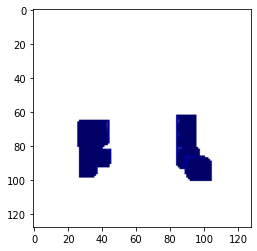

In [8]:
img = obs_expanded[0][test_obs_id].permute(1,2,0)
plt.imshow(img)

In [9]:
obs_expanded.shape

torch.Size([5, 70, 3, 128, 128])

In [10]:
sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)
sampled_obs = generative_model.get_obs_loc(sampled_latent)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])


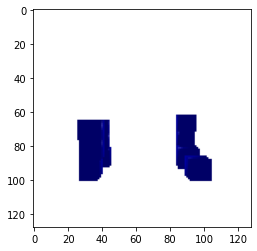

In [11]:
img = sampled_obs.permute(1,2,0).detach().numpy()
plt.imshow(img)

In [12]:
obs_expanded.shape

torch.Size([5, 70, 3, 128, 128])

In [13]:
log_weight.T

tensor([[-45369.2617, -45357.3789, -45357.3086, -45345.2305, -45342.0273],
        [-45365.5781, -45368.5664, -45363.9375, -45353.2695, -45347.0938],
        [-45379.5781, -45370.1875, -45376.9258, -45362.9336, -45362.3633],
        [-45307.5625, -45305.0781, -45304.3164, -45306.1016, -45295.9453],
        [-45276.2305, -45273.3828, -45263.0547, -45256.6680, -45261.9141],
        [-45343.0586, -45342.2969, -45335.8203, -45329.7422, -45326.5898],
        [-45454.2188, -45455.6914, -45449.0312, -45450.8359, -45456.9805],
        [-45403.0977, -45402.7461, -45397.0039, -45396.0078, -45393.3945],
        [-45320.5586, -45315.8164, -45316.2266, -45311.5234, -45312.6641],
        [-45236.7812, -45238.1562, -45234.7383, -45227.8047, -45224.7969],
        [-45245.7344, -45257.1172, -45251.2539, -45250.3750, -45240.6016],
        [-45281.5547, -45280.0078, -45280.7656, -45278.0273, -45278.7656],
        [-45349.3477, -45343.3594, -45346.6797, -45342.5312, -45344.6992],
        [-45232.5625, -45

In [14]:
log_weight.T[0][0].item() < log_weight.T[0][1].item()

True

yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
adding title!
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])


KeyboardInterrupt: 

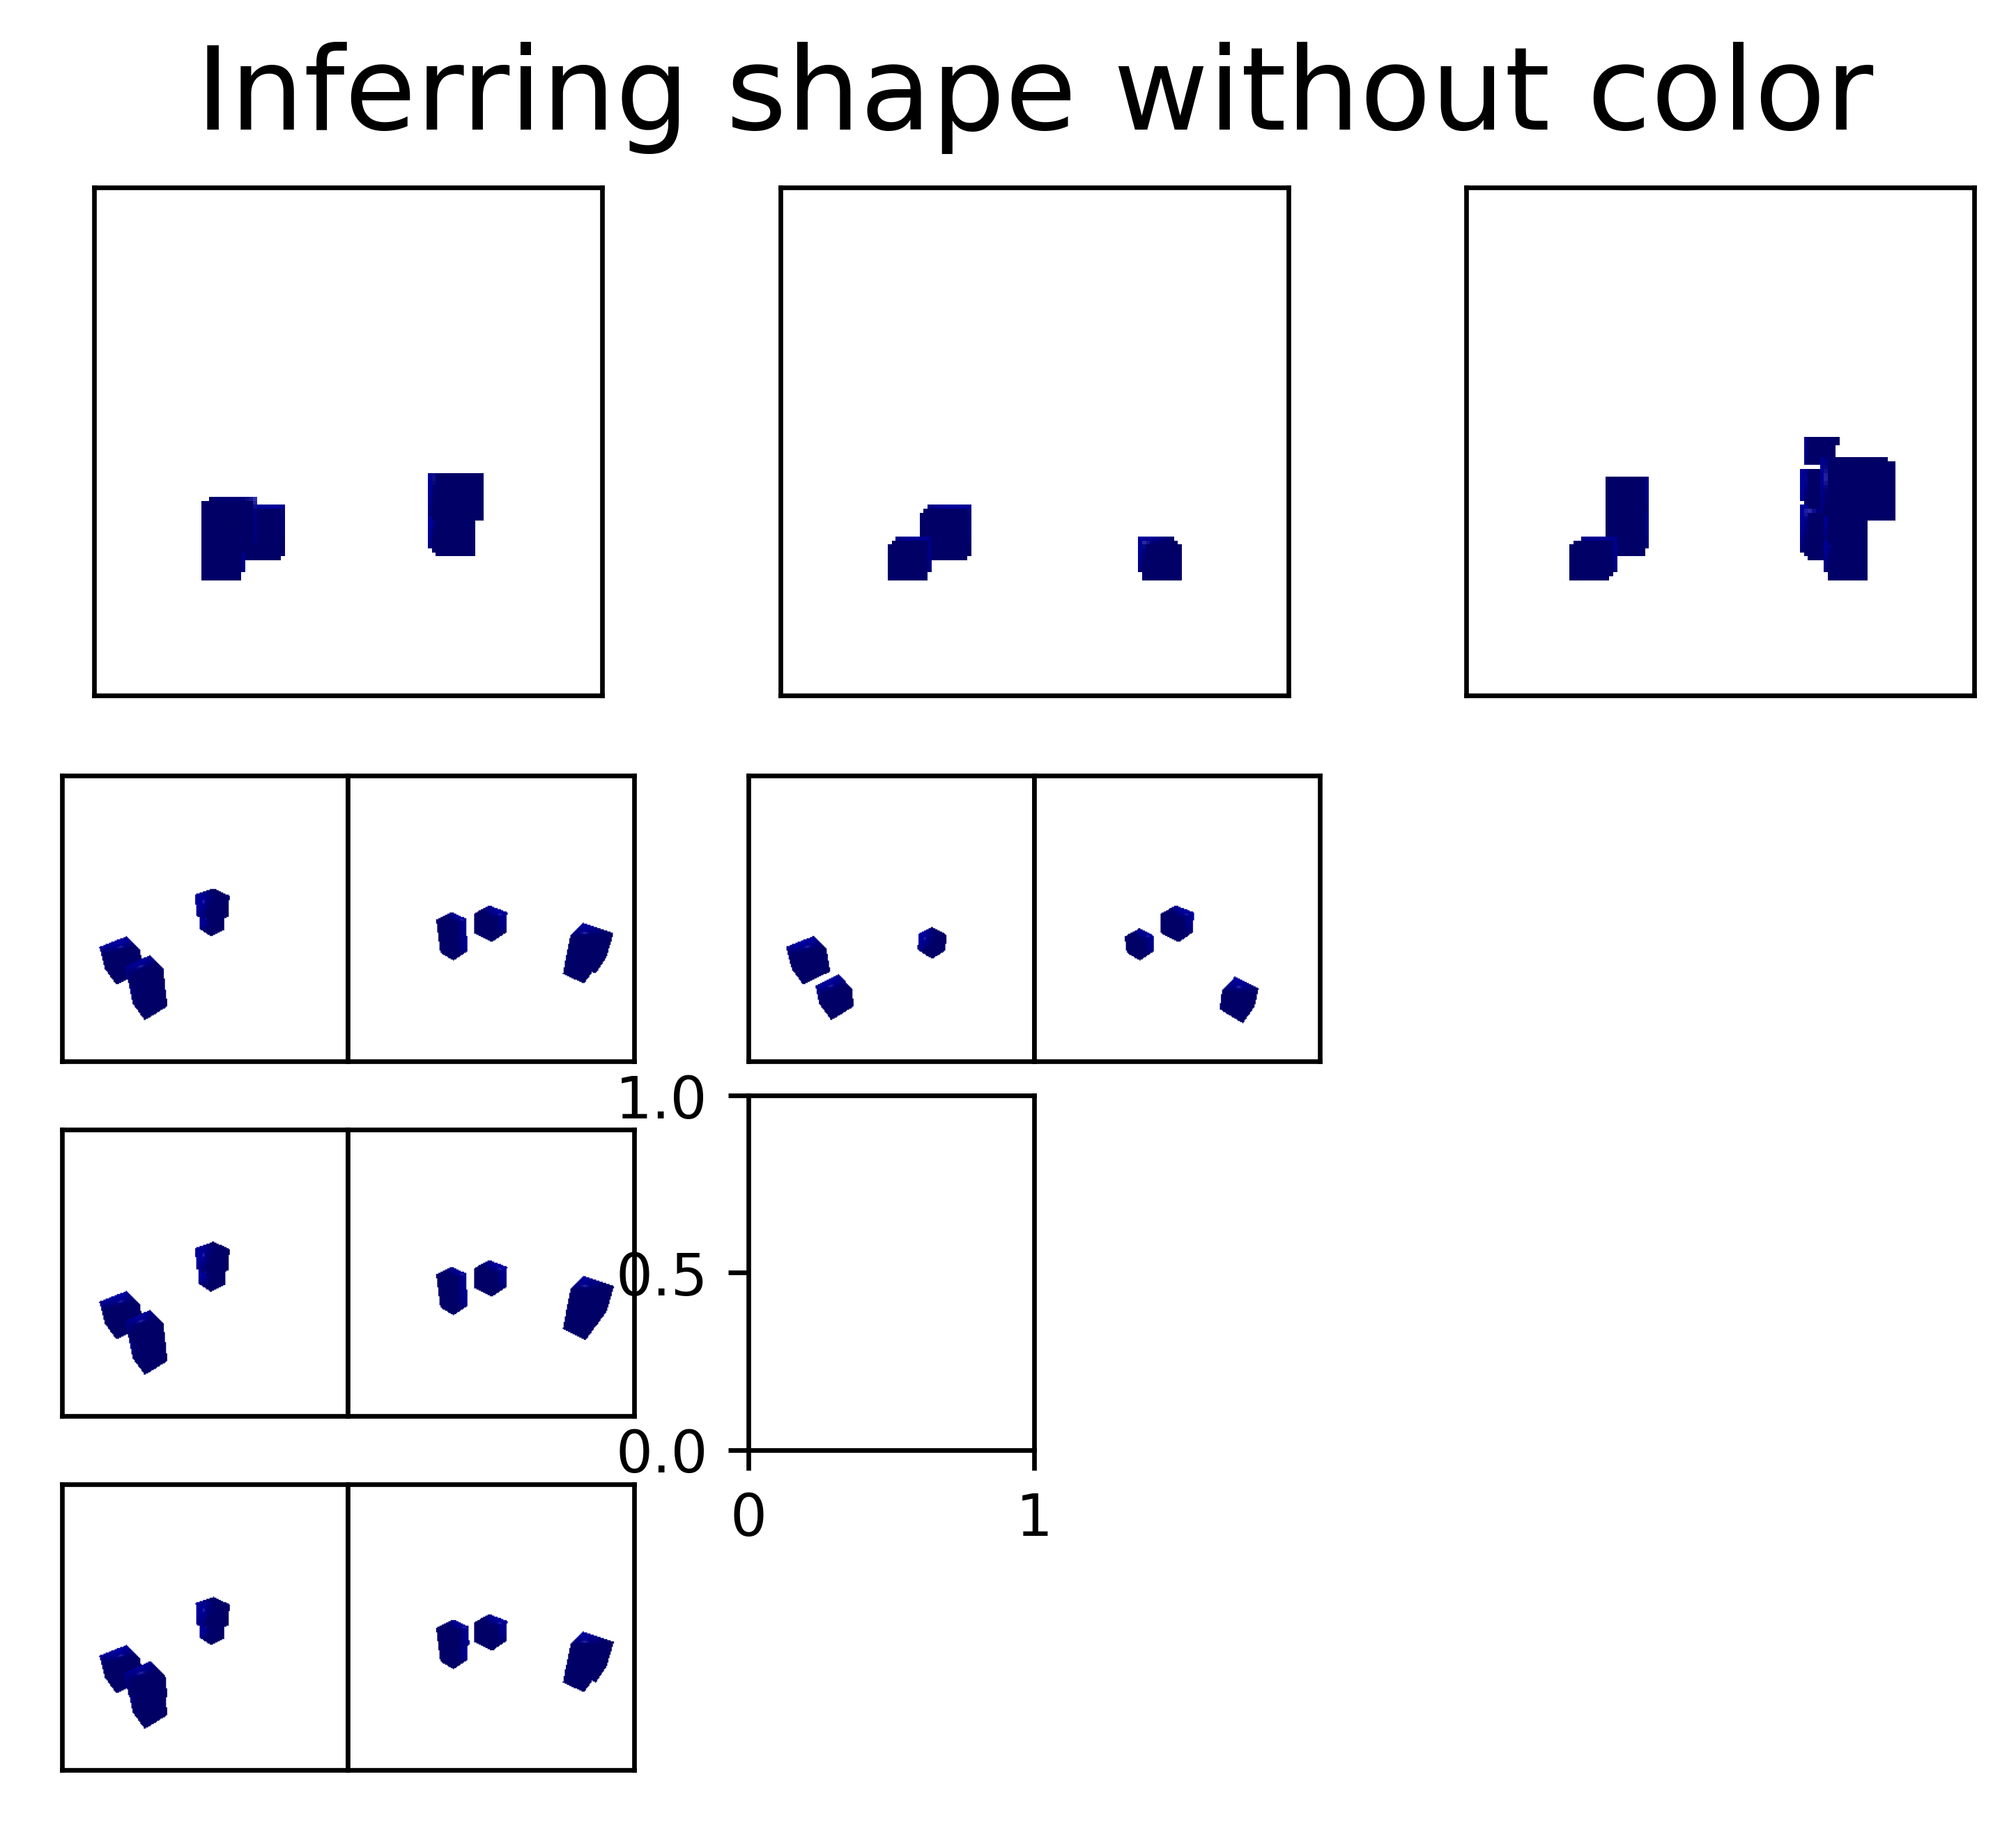

In [15]:
import matplotlib.gridspec as gridspec
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

rows = 7
cols = 3#5

# for the samples from memory
views = [-40, 40] # azimuths
num_views = len(views)
num_samples = 3

example_idxs = [22, 29, 31]#[9, 33, 25+7]

num_primitives = generative_model.num_primitives

# gridspec inside gridspec
f = plt.figure(figsize=(6,6), dpi=600)
# f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

high_res_img = 256

generative_model.im_size = high_res_img#512 # change for higher res

for x in range(rows):
    if x == 1: continue 
    if x >= 3: 
        if x == rows-1: # show primitives
            # 1 row, num primitives = num cols
            print("in grid spec")
            gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
                                               wspace=0.025, hspace=0)
            # Init
            location = torch.tensor([0, 0, -1], device=device).float()
            for i in range(num_primitives): 
                print("primitive: ", i)
                ax = f.add_subplot(gs00[0, i])
                obs = render.render_block(
                    generative_model.primitives[i].size,
                    generative_model.primitives[i].color,
                    location,
                    im_size=high_res_img,
                    remove_color=run_args.remove_color==1,
                    mode="cube",
                )
                ax.imshow(obs.detach().numpy())
                print("created image: ", obs.shape)
                ax.set_xticks([])
                ax.set_yticks([])
#                 if i == 0: # middle entry
#                     ax.set_ylabel(f'Primitives', fontsize=10, fontfamily='serif')
            continue # skip the inner loop of cols 
        else: continue 
    for y in range(cols):
        test_obs_id = example_idxs[y] 
        if x == 0: # observations 
            ax = f.add_subplot(gs0[:2, y])
            img = obs_expanded[0][test_obs_id].permute(1,2,0)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
#             if y == 0: # middle entry
#                 ax.set_ylabel(f'Observations', fontsize=10, fontfamily='serif')
            if y == 1: # middle
                ax.set_title("Inferring shape without color", fontsize=20, pad=10)
        else: 
            gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
                                               wspace=0.0, hspace=0.0)#wspace=0.025, hspace=0.0)
            for xx in range(num_samples): 
                for yy in range(num_views): 
                    print("yy: ", yy)
                    ax = f.add_subplot(gs00[xx, yy])
                    
                    particle_id = xx
                    sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                    num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                    stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                    raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                    sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                    camera_elevation = 30
                    camera_azimuth = views[yy]

                    sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                    img = sampled_obs.permute(1,2,0).detach().numpy()
                    ax.imshow(img)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    if y == 0 and yy == 0 and xx == 1: # middle entry
                        print("adding title!")
                        #ax.set_ylabel(f'Posterior Samples', fontsize=10, fontfamily='serif')

path = "noColor_samples.pdf"
util.save_fig(f, path, dpi=400)



In [ ]:
import matplotlib.gridspec as gridspec
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

rows = 7
cols = 4#5

# for the samples from memory
views = [-40, 40] # azimuths
num_views = len(views)
num_samples = 3

example_idxs = [21,25,16,6]#list(range(20,30))

num_primitives = generative_model.num_primitives

# gridspec inside gridspec
f = plt.figure(figsize=(6,6), dpi=600)
# f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

high_res_img = 256

generative_model.im_size = high_res_img#512 # change for higher res

for x in range(rows):
    if x == 1: continue 
    if x >= 3: 
        if x == rows-1: # show primitives
            # 1 row, num primitives = num cols
            print("in grid spec")
            gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
                                               wspace=0.025, hspace=0)
            # Init
            location = torch.tensor([0, 0, -1], device=device).float()
            for i in range(num_primitives): 
                print("primitive: ", i)
                ax = f.add_subplot(gs00[0, i])
                obs = render.render_block(
                    generative_model.primitives[i].size,
                    generative_model.primitives[i].color,
                    location,
                    im_size=high_res_img,
                    remove_color=run_args.remove_color==1,
                    mode="cube",
                )
                ax.imshow(obs.detach().numpy())
                print("created image: ", obs.shape)
                ax.set_xticks([])
                ax.set_yticks([])
#                 if i == 0: # middle entry
#                     ax.set_ylabel(f'Primitives', fontsize=10, fontfamily='serif')
            continue # skip the inner loop of cols 
        else: continue 
    for y in range(cols):
        test_obs_id = example_idxs[y] 
        if x == 0: # observations 
            ax = f.add_subplot(gs0[:2, y])
            img = obs_expanded[0][test_obs_id].permute(1,2,0)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
#             if y == 0: # middle entry
#                 ax.set_ylabel(f'Observations', fontsize=10, fontfamily='serif')
            if y == 1: # middle
                ax.set_title("Inferring shape without color", fontsize=20, pad=10)
        else: 
            gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
                                               wspace=0.0, hspace=0.0)#wspace=0.025, hspace=0.0)
            for xx in range(num_samples): 
                for yy in range(num_views): 
                    print("yy: ", yy)
                    ax = f.add_subplot(gs00[xx, yy])
                    
                    particle_id = xx
                    sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                    num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                    stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                    raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                    sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                    camera_elevation = 30
                    camera_azimuth = views[yy]

                    sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                    img = sampled_obs.permute(1,2,0).detach().numpy()
                    ax.imshow(img)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    if y == 0 and yy == 0 and xx == 1: # middle entry
                        print("adding title!")
                        #ax.set_ylabel(f'Posterior Samples', fontsize=10, fontfamily='serif')

path = "noColor_samples_debug.pdf"
util.save_fig(f, path, dpi=200)



In [16]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


col_headersize = 11
# inches
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

axis_size = 14
title_size = 20

# select cars + imgs for context views
# all_items = os.listdir(model_sample_dirs[0][0])
# car_id = np.random.choice(all_items, 1)[0]

# for the samples from memory
views = [0, -40, 40] # azimuths
num_views = len(views)
num_samples = 3 

example_idxs = [9,50+16,25+7]#[9, 11, 25+7]#[9, 15, 25+7] #[8, 14, 15, 20, 23, 26][10,11,12,13,27,37,39]

num_primitives = generative_model.num_primitives

high_res_img = 256

# Get the 3 context views
#ctxt_imgs = [os.path.join(specific_views_dir, car_id, "rgb", convert_view2file(idx)) for idx in range(3)]

# Get 3 samples for single, double, and triple views
#view_ids = 0, 1, 2

rows = len(example_idxs) # number of examples 
cols = 2 # observation + hmws 

# gridspec inside gridspec
f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

for x in range(rows):
    
    test_obs_id = example_idxs[x]
    
    # Context images
    ax = f.add_subplot(gs0[x, 0])
    if not x: ax.set_title("Observations", fontsize=axis_size, pad=2.)
    img = obs_expanded[0][test_obs_id].permute(1,2,0)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
#     if x == 0: 
#         #ax.set_ylabel(f'Observations', fontsize=axis_size)#, fontfamily='serif')
#         axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
# #                 axins = inset_axes(ax, width=0.4, height=0.3)#(ax, width=1.3, height=0.9)
#         minimap = plt.imread("../front_camera.png")
#         axins.imshow(minimap)
#         axins.set_xticks([])
#         axins.set_yticks([])
#         axins.axis('off')
    
    for y in range(cols - 1):
        gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x, y + 1], 
                                                wspace=-0.01, hspace=-0.3)#wspace=0.05, hspace=-0.3)
        # One row per sample
        for xx in range(3):
            # One column per view
            for yy in range(3):
                ax = f.add_subplot(gs00[xx, yy])
                particle_id = xx
                sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                
                camera_azimuth = views[yy]
                if camera_azimuth == 0: camera_elevation = 0.1 # default
                else: camera_elevation = 30

                sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                img = sampled_obs.permute(1,2,0).detach().numpy()
                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])

                if not x and not xx and yy == 1: # First outer row, first inner row, center plot
                    ax.set_title("Posterior Samples", fontsize=axis_size, pad=10.)

                if not yy and not y: # Leftmost view of samples
                    ax.set_ylabel(f'Sample {xx+1}', fontsize=10)
                
#                 if x == 0 and xx == 0: 
#                     axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
#                     if yy == 0: minimap = plt.imread("../front_camera.png")
#                     elif yy == 1: minimap = plt.imread("../left_camera.png")
#                     elif yy == 2: minimap = plt.imread("../right_camera.png")
#                     axins.imshow(minimap)
#                     axins.set_xticks([])
#                     axins.set_yticks([])
#                     axins.axis('off')

f.suptitle("Inferring shape without color", fontsize=20)#, pad=10)
f.tight_layout()
path = "noColor_samples.pdf"
util.save_fig(f, path, dpi=400)
plt.close(f)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1,

In [18]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


col_headersize = 11
# inches
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

axis_size = 14
title_size = 20

# select cars + imgs for context views
# all_items = os.listdir(model_sample_dirs[0][0])
# car_id = np.random.choice(all_items, 1)[0]

# for the samples from memory
views = [0, -40, 40] # azimuths
num_views = len(views)
num_samples = 3 

example_idxs = [25+7,9,50+16]#[0, 1,2]

num_primitives = generative_model.num_primitives

high_res_img = 256
generative_model.im_size = high_res_img

# Get the 3 context views
#ctxt_imgs = [os.path.join(specific_views_dir, car_id, "rgb", convert_view2file(idx)) for idx in range(3)]

# Get 3 samples for single, double, and triple views
#view_ids = 0, 1, 2

rows = len(example_idxs) # number of examples 
cols = 3 # observation + hmws 

# gridspec inside gridspec
f = plt.figure(figsize=(text_width, (3/2) * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

for x in range(rows):
    
    test_obs_id = example_idxs[x]
    
    # Context images
    ax = f.add_subplot(gs0[x, 0])
    if not x: ax.set_title("Observations", fontsize=axis_size, pad=10.)
    img = obs_expanded[0][test_obs_id].permute(1,2,0)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
#     if x == 0: 
#         #ax.set_ylabel(f'Observations', fontsize=axis_size)#, fontfamily='serif')
#         axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
# #                 axins = inset_axes(ax, width=0.4, height=0.3)#(ax, width=1.3, height=0.9)
#         minimap = plt.imread("../front_camera.png")
#         axins.imshow(minimap)
#         axins.set_xticks([])
#         axins.set_yticks([])
#         axins.axis('off')
    
    for y in range(cols - 1):
        if y == 1: continue
        gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x, y + 1:], 
                                                wspace=-0.57, hspace=0.0)#wspace=0.05, hspace=-0.3)
        # One row per sample
        for xx in range(3):
            # One column per view
            for yy in range(3):
                ax = f.add_subplot(gs00[xx, yy])
                particle_id = xx
                sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                
                camera_azimuth = views[yy]
                if camera_azimuth == 0: camera_elevation = 0.1 # default
                else: camera_elevation = 30

                sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                img = sampled_obs.permute(1,2,0).detach().numpy()
                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])

                if not x and not xx and yy == 1: # First outer row, first inner row, center plot
                    ax.set_title("Posterior Samples", fontsize=axis_size, pad=6.)

                if not yy and not y: # Leftmost view of samples
                    ax.set_ylabel(f'Sample {xx+1}', fontsize=10)
                
#                 if x == 0 and xx == 0: 
#                     axins = inset_axes(ax, width="40%", height="30%")#(ax, width=1.3, height=0.9)
#                     if yy == 0: minimap = plt.imread("../front_camera.png")
#                     elif yy == 1: minimap = plt.imread("../left_camera.png")
#                     elif yy == 2: minimap = plt.imread("../right_camera.png")
#                     axins.imshow(minimap)
#                     axins.set_xticks([])
#                     axins.set_yticks([])
#                     axins.axis('off')

# 
f.tight_layout()
f.suptitle("Inferring scene parse without color", fontsize=20)#, pad=10)
path = "noColor_samples.pdf"
util.save_fig(f, path, dpi=400)
plt.close(f)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1,

In [ ]:
# import matplotlib.gridspec as gridspec
# text_width = 6.75
# column_width = 6.5 / 2.
# text_height = 9.
# golden = (1 + 5 ** 0.5) / 2 # golden ratio

# rows = 4
# cols = 3#5

# # for the samples from memory
# views = [-40, 40] # azimuths
# num_views = len(views)
# num_samples = 3 

# num_primitives = generative_model.num_primitives

# # gridspec inside gridspec
# f = plt.figure(figsize=(8,6), dpi=600)
# # f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
# gs0 = gridspec.GridSpec(rows, cols, figure=f)

# high_res_img = 256

# generative_model.im_size = high_res_img#512 # change for higher res

# for x in range(rows):
#     if x >= 2: 
#         if x == 3: # show primitives
#             # 1 row, num primitives = num cols
#             print("in grid spec")
#             gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
#                                                wspace=0.025, hspace=0)
#             # Init
#             location = torch.tensor([0, 0, -1], device=device).float()
#             for i in range(num_primitives): 
#                 print("primitive: ", i)
#                 ax = f.add_subplot(gs00[0, i])
#                 obs = render.render_block(
#                     generative_model.primitives[i].size,
#                     generative_model.primitives[i].color,
#                     location,
#                     im_size=high_res_img,
#                     remove_color=run_args.remove_color==1,
#                     mode="cube",
# #                     camera_elevation=30,
# #                     camera_azimuth=40
#                 )
#                 ax.imshow(obs.detach().numpy())
#                 print("created image: ", obs.shape)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 if i == 0: # middle entry
#                     ax.set_ylabel(f'Primitives', fontsize=10, fontfamily='serif')
#             continue # skip the inner loop of cols 
#         else: continue 
#     for y in range(cols):
#         test_obs_id = y 
#         if x == 0: # observations 
#             ax = f.add_subplot(gs0[x, y])
#             img = obs_expanded[0][test_obs_id].permute(1,2,0)
#             ax.imshow(img)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             if y == 0: # middle entry
#                 ax.set_ylabel(f'Observations', fontsize=10, fontfamily='serif')
#             if y == 1: # middle
#                 ax.set_title("Learning Shape Only", fontsize=20, fontfamily='serif')
#         else: 
#             gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
#                                                wspace=-0.5, hspace=0.0)#wspace=0.025, hspace=0.0)
#             for xx in range(num_samples): 
#                 for yy in range(num_views): 
#                     print("yy: ", yy)
#                     ax = f.add_subplot(gs00[xx, yy])
                    
#                     particle_id = xx
#                     sorted_particle_id = sorted_indices[test_obs_id, particle_id]

#                     num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
#                     stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
#                     raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

#                     sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

#                     camera_elevation = 30
#                     camera_azimuth = views[yy]

#                     sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

#                     img = sampled_obs.permute(1,2,0).detach().numpy()
#                     ax.imshow(img)
#                     ax.set_xticks([])
#                     ax.set_yticks([])
#                     if y == 0 and yy == 0 and xx == 1: # middle entry
#                         print("adding title!")
#                         ax.set_ylabel(f'Posterior Samples', fontsize=10, fontfamily='serif')

# path = "noColor_samples.pdf"
# util.save_fig(f, path, dpi=200)



In [ ]:
experiment_name_color = "cmws_vs_rws_learnColor"
device = "cpu"
save_dir = f"../save/{experiment_name_color}"
checkpoint_paths = []
for config_name in sorted(os.listdir(save_dir)):
    checkpoint_paths.append(util.get_checkpoint_path(experiment_name, config_name, -1))
checkpoint_path_color = f'save/{experiment_name_color}/cmws_5_2_0.01_2/checkpoints/latest.pt'#checkpoint_paths[0]
checkpoint_path_color = f"../{checkpoint_path_color}"
model_color, optimizer_color, stats_color, run_args_color = scene3d_util.load_checkpoint(
                            checkpoint_path_color, device="cpu"
                        )
generative_model_color, guide_color = model_color["generative_model"], model_color["guide"]
num_iterations = len(stats_color.losses) # note: can use to filter out jobs!
save_dir = util.get_save_dir(run_args_color.experiment_name, run.get_config_name(run_args_color))

# Plot stats
plot_stats(f"{save_dir}/stats.png", stats_color)

# Plot reconstructions and other things
# Test data
# NOTE: Plotting the train dataset only
train_dataset_color = data.SceneUnderstandingDataset(
    device, run_args_color.num_grid_rows, run_args_color.num_grid_cols, test=False,
    remove_color=(run_args.remove_color == 1),
    mode=run_args_color.mode
)
obs_color, obs_id_color = train_dataset_color[:10]

memory_color = model_color["memory"]

obs_color = obs_color.squeeze(1)
num_test_obs, num_channels, im_size, _ = obs_color.shape
im_size = 128
num_samples = 1

num_particles = memory_color.size
latent, log_weight = importance_sample_memory(
    num_particles, obs, obs_id, generative_model_color, guide_color, memory_color, im_size
)

num_blocks, stacking_program, raw_locations = latent

# Sort by log weight
# [num_test_obs, num_particles], [num_test_obs, num_particles]
_, sorted_indices = torch.sort(log_weight.T, descending=True)

# Sample predictions
# -- Expand obs
obs_expanded = obs[None].expand(num_particles, num_test_obs, 3, im_size, im_size)

In [ ]:
num_primitives